# Assignment 4

The objective of this assignment is to introduce you to federated learning, with a particular focus on the challenges posed by data heterogeneity. Specifically, you will explore well-known approaches for addressing statistical heterogeneity, approaching the problem from multiple angles.

You have been provided with a manual that includes detailed descriptions of each task. Follow the instructions in the manual carefully, and add your answers and implementations directly in this notebook.

Note: In this assignment, we concentrate on one common type of statistical heterogeneity: label skew. While feature skew is another significant aspect of heterogeneity, it will not be the focus of this assignment.

In [1]:
import os
import torch
from torchvision import datasets, transforms
import pickle
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from collections import defaultdict
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from torch.utils.data import Subset

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Calculate sizes for training and testing datasets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Define fixed indices for train and test splits
train_indices = list(range(train_size))
test_indices = list(range(train_size, len(dataset)))

# Create Subsets based on these indices
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

train_images = dataset.data[train_dataset.indices].numpy()
train_labels = dataset.targets[train_dataset.indices].numpy()
test_images = dataset.data[test_dataset.indices].numpy()
test_labels = dataset.targets[test_dataset.indices].numpy()


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.59MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.08MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
def partition_data(train_data, train_targets, test_data, test_targets, num_clients, dirichlet_alpha=0.5, batch_size=32):
    num_classes = len(np.unique(train_targets))
    client_data_indices = defaultdict(list)
    client_test_indices = defaultdict(list)

    # Partition Train Data and Capture Proportions
    client_proportions = []
    for c in range(num_classes):
        class_indices = np.where(train_targets == c)[0]
        proportions = np.random.dirichlet([dirichlet_alpha] * num_clients)
        client_proportions.append(proportions)

        # Calculate split sizes and assign indices to each client
        split_sizes = (np.cumsum(proportions) * len(class_indices)).astype(int)[:-1]
        client_indices_split = np.split(class_indices, split_sizes)

        for i, indices in enumerate(client_indices_split):
            client_data_indices[i].extend(indices)

    # Partition Test Data Using the Same Proportions as Train Data
    for c, proportions in enumerate(client_proportions):
        class_indices = np.where(test_targets == c)[0]
        split_sizes = (np.cumsum(proportions) * len(class_indices)).astype(int)[:-1]
        client_indices_split = np.split(class_indices, split_sizes)

        for i, indices in enumerate(client_indices_split):
            client_test_indices[i].extend(indices)

    # Create Federated Loaders
    federated_train_loaders, federated_test_loaders = [], []
    for i in range(num_clients):
        client_train_data = torch.tensor(train_data[client_data_indices[i]], dtype=torch.float32).unsqueeze(1)
        client_train_targets = torch.tensor(train_targets[client_data_indices[i]], dtype=torch.long)
        train_loader = DataLoader(TensorDataset(client_train_data, client_train_targets), batch_size=batch_size, shuffle=False, drop_last=False)
        federated_train_loaders.append(train_loader)

        client_test_data = torch.tensor(test_data[client_test_indices[i]], dtype=torch.float32).unsqueeze(1)
        client_test_targets = torch.tensor(test_targets[client_test_indices[i]], dtype=torch.long)
        test_loader = DataLoader(TensorDataset(client_test_data, client_test_targets), batch_size=batch_size, shuffle=False, drop_last=False)
        federated_test_loaders.append(test_loader)

    # Create Centralized Loader by combining data from federated loaders
    centralized_data, centralized_targets = [], []
    for train_loader in federated_train_loaders:
        for images, targets in train_loader:
            centralized_data.append(images)
            centralized_targets.append(targets)

    centralized_data = torch.cat(centralized_data)
    centralized_targets = torch.cat(centralized_targets)
    train_centralized_loader = DataLoader(TensorDataset(centralized_data, centralized_targets), batch_size=batch_size, shuffle=False, drop_last=False)

    centralized_test_data = torch.tensor(test_data, dtype=torch.float32).unsqueeze(1)
    centralized_test_targets = torch.tensor(test_targets, dtype=torch.long)
    test_centralized_loader = DataLoader(TensorDataset(centralized_test_data, centralized_test_targets), batch_size=batch_size, shuffle=False)

    return federated_train_loaders, federated_test_loaders, train_centralized_loader, test_centralized_loader


In [4]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 500)
        self.fc2 = nn.Linear(500,10)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Task 1: Centralized Vs Federated Scenario
In this task, you will analyze the theoretical equivalence between FedSGD and a centralized training scenario. The code for both implementations has been provided. To minimize differences caused by floating-point precision, a batch size of 1 is used, along with full-batch gradient descent. You may change the device to cpu if you wish, as gpu will not be utilized for batch size of 1.

Since we are working with batch size 1 and full-batch gradient descent, accuracy is not the focus here. Instead, you will monitor gradient divergence by tracking the sum or magnitude of the gradients at each round and observe how they evolve in both settings.

Theoretically, FedSGD and centralized training should yield equivalent results. However, in this task, you may observe discrepancies. Your objective is to understand the code and identify the error that causes this divergence. You may want to review why FedSGD and full-batch centralized gradient descent are theoretically equivalent by revisiting the gradient descent steps on the global objective, as covered in class. Finally, assess whether the code aligns with these theoretical steps. If you believe they should not be equivalent, provide a reasoned justification.

In [5]:
num_clients = 5
dirichlet_alpha = 0.8
batch_size = 1

# Partition data and create loaders
federated_train_loaders, federated_test_loaders, train_centralized_loader, test_centralized_loader = partition_data(
    train_images / 255.0, train_labels, test_images / 255.0, test_labels, num_clients, dirichlet_alpha, batch_size
)

In [6]:
def fedsgd_training(global_model, train_loaders, num_clients, rounds, lr):
    round_avg_updates = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    global_model.to(device)
    print(f"Using device: {device}")

    client_data_counts = [len(train_loader.dataset) for train_loader in train_loaders]
    total_data_count = 0
    for count in client_data_counts:
        total_data_count += count

    for round_num in range(rounds):
        client_updates = []
        print(f"Round {round_num + 1}/{rounds}")

        for client_id in range(num_clients):
            overall_update = local_train(global_model, train_loaders[client_id], lr)
            client_update_device = {name: update.to(device) for name, update in overall_update.items()}
            client_updates.append(client_update_device)

            client_update_sum = 0
            for update in client_update_device.values():
                client_update_sum += update.abs().sum().item()
            print(f"Client {client_id + 1} Update Sum at Round {round_num + 1}: {client_update_sum}")

        avg_update = {}
        for name in global_model.state_dict():
            grad_sum = torch.zeros_like(global_model.state_dict()[name], device=device)
            for client_id in range(num_clients):
                # grad_sum += client_updates[client_id][name] * (client_data_counts[client_id] / total_data_count) #weighted avg
                grad_sum += client_updates[client_id][name]
            avg_update[name] = grad_sum

        round_avg_updates.append(avg_update)

        avg_update_sum = 0
        for update in avg_update.values():
            avg_update_sum += update.abs().sum().item()
        print(f"Averaged Update Sum at Round {round_num + 1}: {avg_update_sum}")

        with torch.no_grad():
            for name, param in global_model.named_parameters():
                param -= avg_update[name]

    return round_avg_updates



def local_train(model, train_loader, lr):
    local_model = SimpleCNN()
    local_model.load_state_dict(model.state_dict())
    local_model.train()

    optimizer = optim.SGD(local_model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(reduction="sum")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    local_model.to(device)

    initial_weights = {name: param.clone() for name, param in local_model.named_parameters()}

    for epoch in range(1):
        print(f"Epoch {epoch + 1}/{1} for local client")
        optimizer.zero_grad()
        batch_iterator = tqdm(train_loader, desc=f"Training Batches (Epoch {epoch + 1})")

        # Loop over batches
        for x_train, y_train in batch_iterator:
            x_train, y_train = x_train.to(device), y_train.to(device)
            outputs = local_model(x_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            batch_iterator.set_postfix(loss=loss.item())

        optimizer.step()

    overall_update = {name: initial_weights[name] - param for name, param in local_model.named_parameters()}

    return overall_update


In [7]:
def centralized_training_updates(global_model, train_loader, epochs, lr):
    centralized_model = SimpleCNN()
    centralized_model.load_state_dict(global_model.state_dict())
    centralized_model.train()

    optimizer = optim.SGD(centralized_model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(reduction="sum")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    centralized_model.to(device)

    epoch_updates = []

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        epoch_initial_weights = {name: param.clone() for name, param in centralized_model.named_parameters()}
        optimizer.zero_grad()
        batch_iterator = tqdm(train_loader, desc=f"Training Batches (Epoch {epoch + 1})")

        for x_train, y_train in batch_iterator:
            x_train, y_train = x_train.to(device), y_train.to(device)
            outputs = centralized_model(x_train)
            loss = criterion(outputs, y_train)
            loss.backward()

            batch_iterator.set_postfix(loss=loss.item())

        optimizer.step()

        epoch_update = {name: param - epoch_initial_weights[name]  for name, param in centralized_model.named_parameters()}
        epoch_updates.append(epoch_update)

        epoch_update_sum = 0
        for update in epoch_update.values():
            epoch_update_sum += update.abs().sum().item()

        print(f"Epoch {epoch + 1} Update Sum: {epoch_update_sum}")

    global_model.load_state_dict(centralized_model.state_dict())

    return epoch_updates


In [8]:
# Initialize model and parameters
rounds = 4
lr = 1e-4
initial_model = SimpleCNN()

In [9]:
# Centralized Training
global_model_centralized = SimpleCNN()
global_model_centralized.load_state_dict(initial_model.state_dict())
centralized_updates = centralized_training_updates(global_model_centralized, train_centralized_loader, epochs=rounds, lr=lr)

Using device: cuda
Epoch 1/4


Training Batches (Epoch 1): 100%|██████████| 48000/48000 [04:12<00:00, 190.35it/s, loss=2.37]


Epoch 1 Update Sum: 346.254536151886
Epoch 2/4


Training Batches (Epoch 2): 100%|██████████| 48000/48000 [04:00<00:00, 199.87it/s, loss=2.15]


Epoch 2 Update Sum: 456.67047414183617
Epoch 3/4


Training Batches (Epoch 3): 100%|██████████| 48000/48000 [03:57<00:00, 202.16it/s, loss=4.49]


Epoch 3 Update Sum: 7787.741715192795
Epoch 4/4


Training Batches (Epoch 4): 100%|██████████| 48000/48000 [03:56<00:00, 203.01it/s, loss=6.25]


Epoch 4 Update Sum: 18185.031916618347


In [10]:
# Fedsgd
global_model_fedsgd = SimpleCNN()
global_model_fedsgd.load_state_dict(initial_model.state_dict())
fedsgd_avg_updates = fedsgd_training(global_model_fedsgd, federated_train_loaders, num_clients, rounds=rounds, lr=lr)

Using device: cuda
Round 1/4
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 7759/7759 [00:45<00:00, 171.84it/s, loss=2.36]


Client 1 Update Sum at Round 1: 149.1474380493164
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 12383/12383 [01:02<00:00, 197.88it/s, loss=2.36]


Client 2 Update Sum at Round 1: 348.07404041290283
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 5893/5893 [00:28<00:00, 203.87it/s, loss=2.37]


Client 3 Update Sum at Round 1: 186.9003750681877
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 12505/12505 [01:00<00:00, 205.15it/s, loss=2.38]


Client 4 Update Sum at Round 1: 335.0643692612648
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 9460/9460 [00:45<00:00, 206.30it/s, loss=2.37]


Client 5 Update Sum at Round 1: 249.78418811410666
Averaged Update Sum at Round 1: 346.2545375674963
Round 2/4
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 7759/7759 [00:37<00:00, 204.46it/s, loss=2.15]


Client 1 Update Sum at Round 2: 157.75707814842463
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 12383/12383 [01:00<00:00, 204.99it/s, loss=2.14]


Client 2 Update Sum at Round 2: 390.01701164245605
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 5893/5893 [00:28<00:00, 204.27it/s, loss=2.12]


Client 3 Update Sum at Round 2: 191.72039645537734
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 12505/12505 [01:00<00:00, 205.04it/s, loss=2.16]


Client 4 Update Sum at Round 2: 360.7382324934006
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 9460/9460 [00:46<00:00, 205.60it/s, loss=2.15]


Client 5 Update Sum at Round 2: 306.7097024023533
Averaged Update Sum at Round 2: 456.67027989029884
Round 3/4
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 7759/7759 [00:40<00:00, 191.92it/s, loss=3.42]


Client 1 Update Sum at Round 3: 1811.3806011080742
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 12383/12383 [01:04<00:00, 191.29it/s, loss=3.72]


Client 2 Update Sum at Round 3: 2431.9306106567383
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 5893/5893 [00:30<00:00, 192.34it/s, loss=3.62]


Client 3 Update Sum at Round 3: 1632.3389110565186
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 12505/12505 [01:04<00:00, 193.56it/s, loss=4.6]


Client 4 Update Sum at Round 3: 2855.352305173874
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 9460/9460 [00:49<00:00, 192.54it/s, loss=4.49]


Client 5 Update Sum at Round 3: 1024.4318321347237
Averaged Update Sum at Round 3: 7787.8203818798065
Round 4/4
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 7759/7759 [00:40<00:00, 190.47it/s, loss=5.43]


Client 1 Update Sum at Round 4: 2386.63183259964
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 12383/12383 [01:03<00:00, 193.58it/s, loss=5.9]


Client 2 Update Sum at Round 4: 4800.019139289856
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 5893/5893 [00:30<00:00, 193.98it/s, loss=5.83]


Client 3 Update Sum at Round 4: 1571.5013201236725
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 12505/12505 [01:05<00:00, 189.49it/s, loss=6.16]


Client 4 Update Sum at Round 4: 3607.2541680336
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 9460/9460 [00:47<00:00, 197.12it/s, loss=6.25]

Client 5 Update Sum at Round 4: 5899.508025527
Averaged Update Sum at Round 4: 18184.19758605957


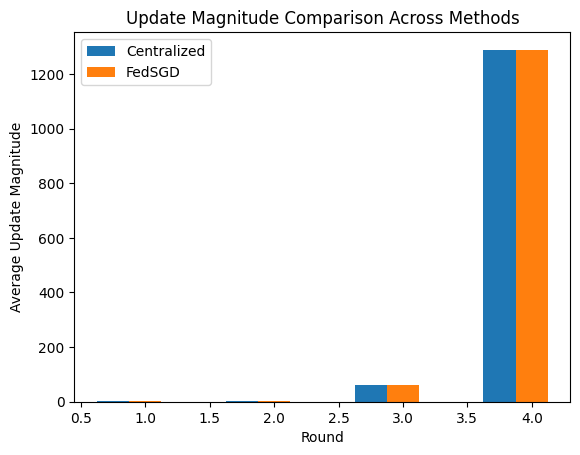

Success! The gradients are approximately the same.


In [11]:
# Calculate update magnitudes for each round
centralized_magnitudes = [sum(param.norm().item() for param in round_update.values()) for round_update in centralized_updates]
fedsgd_magnitudes      = [sum(param.norm().item() for param in update.values())       for update in fedsgd_avg_updates]

# Plot update magnitudes
x_labels = range(1, rounds + 1)
width = 0.25

plt.bar([x - width for x in x_labels], centralized_magnitudes, width=width, label="Centralized")
plt.bar(x_labels, fedsgd_magnitudes, width=width, label="FedSGD")
plt.xlabel("Round")
plt.ylabel("Average Update Magnitude")
plt.title("Update Magnitude Comparison Across Methods")
plt.legend()
plt.show()

# Check if the gradients are approximately the same
tolerance = 1e-2
success = all(abs(c - f) <= tolerance for c, f in zip(centralized_magnitudes, fedsgd_magnitudes))

if success:
    print("Success! The gradients are approximately the same.")
else:
    print("Keep trying")